# Cutflow study for mutau at high mas relaxing cuts on muons to increase acceptance

In [1]:
import uproot
import subprocess
import awkward as ak
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import matplotlib.ticker as mtick

In [72]:
needed_branches =  ["GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_eta", "GenPart_phi", "GenPart_pt", "nGenVisTau", "GenVisTau*",
                    "Tau*", "Muon_*", "Electron*"]
######################## V12 skims
def open_file(folder:str, idx):
    try:
       return uproot.open(f"{folder}/nanoHTT_{idx}_0.root:Events")
    except OSError:
    #    try:
        return uproot.open(f"{folder}/nanoHTT_{idx}_1.root:Events")
    #    except OSError:
    #        return uproot.open(f"{folder}/nanoHTT_1_0.root:Events")
# ar_raw = {mass : [open_file(f"root://eos.grif.fr///eos/grif/cms/llr/store/user/evernazz/HTT/Run2_2018/ZprimeToZH_ZToBB_HToTauTau_M-{mass}", idx).arrays(filter_name=needed_branches, how="zip")
#     for idx in range(5)]
#        for mass in [500,600,700,800,1000,1200,1400,1600,1800,2000,2500,3000,3500,4000,4500,5000,5500,6000]}

ar_raw = {mass : [open_file(f"root://eos.grif.fr///eos/grif/cms/llr/store/user/evernazz/HTT/Run2_2018/GluGluToXToZZTo2B2Tau_M-{mass}", idx).arrays(filter_name=needed_branches, how="zip")
    for idx in range(4)]
       for mass in [ 200,  250,  300, 350, 400, 450, 500, 550, # 210, 220, 230, 240, 260, 270, 280,  320,  360,
                600, 650, 700, 750, 800, 850, 900, 1000, 1200,  1400, 1600,
                1800,  2000,   2500,  3000, 3500, 4000, 4500, 5000]}
ar_raw = {mass : ak.concatenate(ars) for mass, ars in ar_raw.items()}

In [73]:
def genPairType_branch(ar):
    """ select etau, mutau, tautau at genlevel"""
    tautau = ar.nGenVisTau == 2

    mutau_genMuon_bool = (abs(ar.GenPart.pdgId) == 13) & (abs(ar.GenPart[ar.GenPart.genPartIdxMother].pdgId) == 15)
    mutau_genMuon_idx = ak.firsts(ak.local_index(ar.GenPart)[mutau_genMuon_bool]) # index of gen muon in GenPart collection
    mutau = (ar.nGenVisTau == 1) & ak.any(mutau_genMuon_bool, axis=-1)
    
    etau_genMuon_bool = (abs(ar.GenPart.pdgId) == 11) & (abs(ar.GenPart[ar.GenPart.genPartIdxMother].pdgId) == 15)
    etau_genMuon_idx = ak.firsts(ak.local_index(ar.GenPart)[etau_genMuon_bool]) # index of gen muon in GenPart collection
    etau = (ar.nGenVisTau == 1) & ak.any(etau_genMuon_bool, axis=-1)
    
    genPairType =  ak.where(mutau, 0, ak.where(etau, 1, ak.where(tautau, 2, -1)))
    genLeptonIdx = ak.where(mutau, mutau_genMuon_idx, etau_genMuon_idx) # for tautau will just put None
    return ak.with_field(ak.with_field(ar, genPairType, where="genPairType"), genLeptonIdx, "genLeptonIdx")
def eff(branch_num, filter_denom):
    try:
        return ak.count_nonzero(branch_num) / ak.count_nonzero(filter_denom)
    except:
        return ak.count_nonzero(branch_num) / len(filter_denom)

def delta_phi(a, b):
    """Compute difference in angle given two angles a and b

    Returns a value within [-pi, pi)
    """
    return (a - b + np.pi) % (2 * np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    r"""Distance in (eta,phi) plane given two pairs of (eta,phi)

    :math:`\sqrt{\Delta\eta^2 + \Delta\phi^2}`
    """
    deta = eta1 - eta2
    dphi = delta_phi(phi1, phi2)
    return np.hypot(deta, dphi)

class DotDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
deeptau=DotDict(
    vsjet=DotDict(VVVLoose=1, VVLoose=2, VLoose=3, Loose=4, Medium=5,
        Tight=6, VTight=7, VVTight=8),
    vse=DotDict(VVVLoose=1, VVLoose=2, VLoose=3, Loose=4, Medium=5,
        Tight=6, VTight=7, VVTight=8),
    vsmu=DotDict(VLoose=1, Loose=1, Medium=3, Tight=4),
)


def match_muon_gen(ar):
    """ Match muon to gen """
    gen_muons = ak.firsts(ar.GenPart[ak.singletons(ar.genLeptonIdx)])
    matched = (delta_r(gen_muons.eta, gen_muons.phi, ar.Muon.eta, ar.Muon.phi) < 0.1)
    return ak.firsts(ar.Muon[matched])

def match_tau_gen(ar):
    """ Match tau to gen """
    gen_taus = ak.firsts(ar.GenVisTau)
    matched = (delta_r(gen_taus.eta, gen_taus.phi, ar.Tau.eta, ar.Tau.phi) < 0.4)
    return ak.firsts(ar.Tau[matched])


In [74]:
ars = {mass:genPairType_branch(ar_raw[mass]) for mass in ar_raw.keys()}
ars_mutau = {mass:ar[ar.genPairType==0] for mass,ar in ars.items()}
ar = ars_mutau[2500]

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

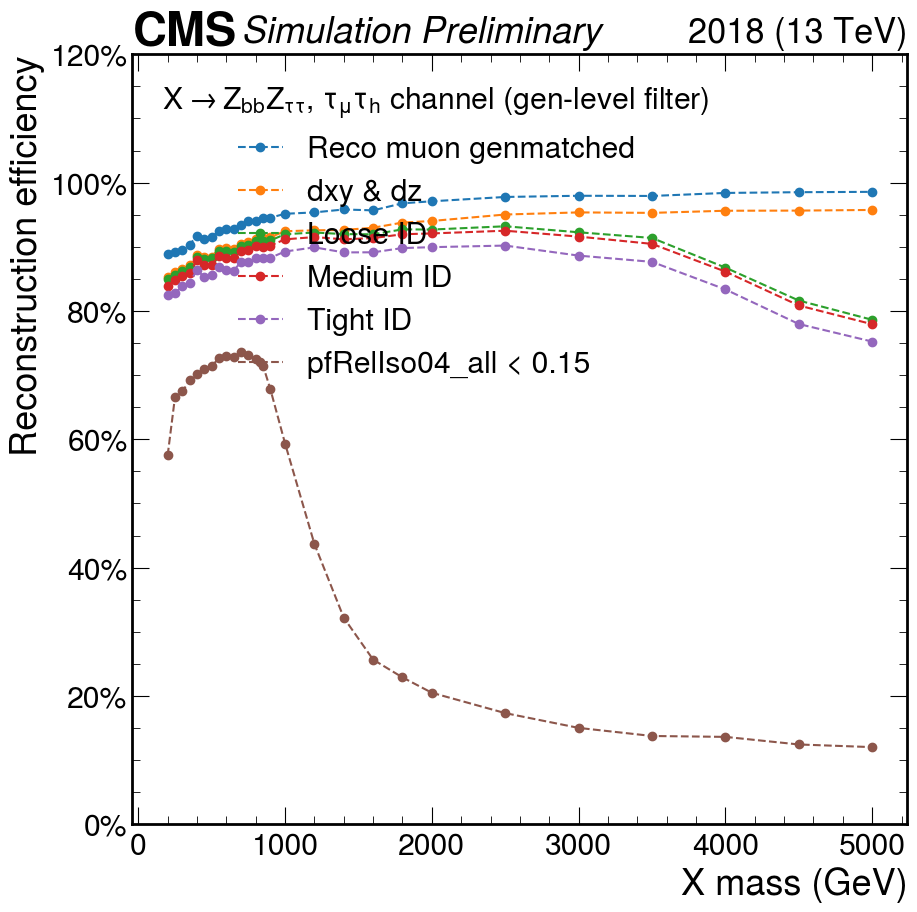

In [75]:
################# MUONS
effs = defaultdict(dict)
for mass, ar in ars_mutau.items():
    genmatched_muons = match_muon_gen(ar)
    cut = ~ak.is_none(genmatched_muons)
    effs["Reco muon genmatched"][mass] = eff(cut, ar)

    cut = cut& (np.abs(genmatched_muons.dxy) <= 0.045) & (np.abs(genmatched_muons.dz) < 0.2)
    effs["dxy & dz"][mass] = eff(cut, ar)

    cut = cut& (genmatched_muons.looseId) 
    effs["Loose ID"][mass] = eff(cut, ar)
    cut = cut& (genmatched_muons.mediumId) 
    effs["Medium ID"][mass] = eff(cut, ar)
    cut = cut& (genmatched_muons.tightId) 
    effs["Tight ID"][mass] = eff(cut, ar)

    cut = cut& (np.abs(genmatched_muons.pfRelIso04_all) <= 0.15) 
    effs["pfRelIso04_all < 0.15"][mass] = eff(cut, ar)

    # eff_singlemu_trigger_genmatched[mass] =ak.count_nonzero(singlemu_trigger_matchGen(ar[genMuTau], singlemu_trigger(ar[genMuTau]))) / ak.count_nonzero(genMuTau)

for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Reconstruction efficiency")
plt.ylim(0, 1.2)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)", loc="upper left")
hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")

In [76]:
ar = ars_mutau[2500]
match_tau_gen(ar)

<Array [{charge: 1, decayMode: 1, ...}, ...] type='6652 * ?{charge: int16, ...'>

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Simulation Preliminary'))

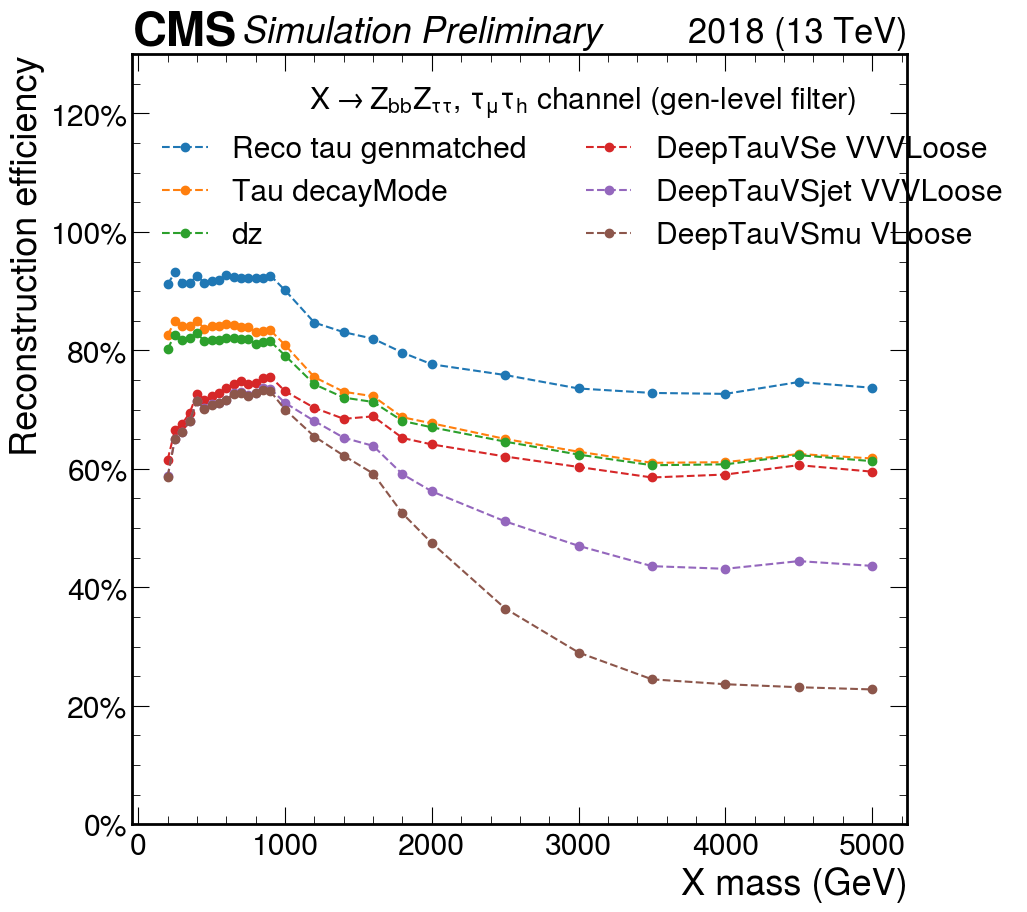

In [81]:
################# TAUS
effs = defaultdict(dict)
for mass, ar in ars_mutau.items():
    genmatched_taus = match_tau_gen(ar)
    cut = ~ak.is_none(genmatched_taus)
    effs["Reco tau genmatched"][mass] = eff(cut, ar)

    cut = cut& ((genmatched_taus.decayMode == 0) | (genmatched_taus.decayMode == 1) | (genmatched_taus.decayMode == 10) |(genmatched_taus.decayMode == 11))
    effs["Tau decayMode"][mass] = eff(cut, ar)

    cut = cut& ((genmatched_taus.dz <=0.2))
    effs["dz"][mass] = eff(cut, ar)

    cut = cut& ((genmatched_taus.idDeepTau2017v2p1VSe >= 1))
    effs["DeepTauVSe VVVLoose"][mass] = eff(cut, ar)

    # cut = cut& ((genmatched_taus.idDeepTau2017v2p1VSe >= 2))
    # effs["DeepTauVSe VVLoose"][mass] = eff(cut, ar)

    cut = cut& ((genmatched_taus.idDeepTau2017v2p1VSjet >= 1))
    effs["DeepTauVSjet VVVLoose"][mass] = eff(cut, ar)

    # cut = cut& ((genmatched_taus.idDeepTau2017v2p1VSjet >= 3))
    # effs["DeepTauVSjet VLoose"][mass] = eff(cut, ar)

    # cut = cut& ((genmatched_taus.idDeepTau2017v2p1VSjet >= 5))
    # effs["DeepTauVSjet Medium"][mass] = eff(cut, ar)

    # cut = cut& ((genmatched_taus.idDeepTau2017v2p1VSmu >= 4))
    # effs["DeepTauVSmu Tight"][mass] = eff(cut, ar)

    cut = cut& ((genmatched_taus.idDeepTau2017v2p1VSmu >= 1))
    effs["DeepTauVSmu VLoose"][mass] = eff(cut, ar)

    # eff_singlemu_trigger_genmatched[mass] =ak.count_nonzero(singlemu_trigger_matchGen(ar[genMuTau], singlemu_trigger(ar[genMuTau]))) / ak.count_nonzero(genMuTau)

for key, val in effs.items():
    plt.plot(val.keys(), val.values(), "o--", label=key)
# plt.plot(ars.keys(), eff_singlemu_trigger_genmatched.values(), label="HLT_IsoMu24 gen-matched")
plt.xlabel("X mass (GeV)")
plt.ylabel("Reconstruction efficiency")
plt.ylim(0, 1.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams['legend.title_fontsize'] = 'small'
plt.legend(title=r"$X\to Z_{bb}Z_{\tau\tau}$, $\tau_{\mu}\tau_{h}$ channel (gen-level filter)", loc="upper left", ncols=2)
hep.cms.label("Preliminary", year=2018)
#plt.savefig("studies/cutflow/cutflow_offline_muon_eff.pdf")